# Terminal Penalty & Terminal Constraint

Consider the discrete-time linear system
$$
x(k+1) = \left[\begin{array}{cc}
2 & 1\\
0 & 2\\
\end{array}\right] x(k) + \left[\begin{array}{cc}
1&0\\
0&1
\end{array} 
\right] u(k),
$$
subject to state constraints $\mathbb{X} \coloneqq \left\{x \in \R^2 \mid x_1 \leq 5 \right\}$ and input constraints $\mathbb{U} \coloneqq \left\{u \in \R^2 \mid -\boldsymbol{1}_2 \leq u \leq \boldsymbol{1}_2  \right\}$. Consider the following cost function with terminal penalty on the final state, $V_{ \textup{f} }(x(N))$,
$$
V(x(0),\boldsymbol{u})=\frac{1}{2}\sum_{k=0}^{N-1}  x(k)^\top Q x(k)+u(k)^\top R u(k) + V_{ \textup{f} }(x(N)),
$$
where $Q = \alpha I_2$, $R = I_2$, $V_{ \textup{f} }(x(N)) = \frac{1}{2} x^\top(N) P x(N) $, and $P$ is the solution of the steady-state Riccati equation. Set $N = 3$ and $\alpha = 10^{-5}$.

- Compute the infinite horizon optimal cost and control law for the unconstrained system.

In [19]:
import numpy as np
from control import dare

A = np.array([
    [2., 1.],
    [0., 2.]
])
B = np.eye(2)
N = 3
dim_x = A.shape[0]
dim_u = B.shape[1]

alpha = 10e-5
Q = alpha * np.eye(2)
R = np.eye(2)
P = np.zeros((2, 2))

P_inf, _, K_inf = dare(A, B, Q, R)
K_inf = -K_inf
print(f"P_inf:\n {P_inf}")
print(f"K_inf:\n {K_inf}")

P_inf:
 [[2.70018166 1.80000333]
 [1.80000333 4.2001163 ]]
K_inf:
 [[-1.35004083 -0.90000167]
 [-0.22498125 -1.65000731]]


## Compute $\mathbb{X}_f$

By using the control law for the unconstrained system, let us consider the following set:
$$
\mathcal{X} \coloneqq \left\{x \in \R^2 \mid x \in \mathbb{X}, \; K x \in \mathbb{U} \right\} = \left\{x \in \R^2 \mid f_i(x) \leq 0, \, i = 1,2,\ldots,s\right\}.
$$

We want to find $\mathbb{X}_f$, the maximal constraint admissible set for the system $x(k+1) = (A + BK) x(k) = A_K x(k)$ with $x \in \mathcal{X}$. The algorithm for constructing this set is described below. 

1. Set $k = 0$.

2. Loop over each constraint $f_i(x)$, and check if the state is still **feasible** after **one-step simulation**, considering the current feasible set.

3. If all constraints are satisfied, set $k^* = k$ and return 
$$
\mathbb{X}_f \coloneqq \left\{x \in \R^n \mid f_i(A_K^{t}x) \leq 0, \;\forall i \in  \{1,2,\ldots,s \}, \; \forall t \in \{ 0, 1,\ldots, k^{\star} \} \right\}.
$$ 

4. If not, set $k = k + 1 $ and go to step 2.

The second step may be a little unclear. Let us take an example. Assuming $x \in \mathcal{X}$, we want to know if $\,x^{+} = A_K x\,$ stays in $\mathcal{X}$. However, it is hard to check every state one by one. Instead, we consider the **worst** state, which can be found by solving the following optimization problem:
$$
x^{\star}_i \coloneqq \left\{
	\begin{aligned}
		&\underset{x}{\textrm{argmax}} & & f_i(A_K^{k+1}x)\\
		&\hspace{.3cm}\textrm{ s.t. } & & f_j(A_K^{t}x) \leq 0, \quad \forall j \in \{1,2,\ldots, s \} , \; \forall t \in \{ 0,1,\ldots,k \}.
	\end{aligned}
\right.
$$

If $f_i(A_K^{k+1}x_i^{\star}) \leq 0 \, $ $\forall i \in \{ 1, 2,\ldots,s \}$ $\longrightarrow$, we can conclude that $\,x^{+} = A_K x\,$ stays in $\mathcal{X}$ for $\forall x \in \mathcal{X}$.

We can also use MPT3 to compute $\mathbb{X}_f$. Please refer to https://www.mpt3.org/pmwiki.php/UI/RegulationProblem#mpctset for more details. We would like to remind readers of the distinction between [$\texttt{invariantSet}$](https://www.mpt3.org/pmwiki.php/UI/Invariance) and [$\texttt{LQRSet}$](https://www.mpt3.org/pmwiki.php/UI/RegulationProblem#mpctset) in MPT3. 

In [20]:
import numpy as np
from control import dlqr    
%matplotlib ipympl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, HalfspaceIntersection
from shapely.geometry import Polygon
import geopandas as gpd
from scipy.optimize import linprog

def compute_maximal_admissible_set(F, A, b, max_iter=100):
    '''
    Compute the maximal admissible set for the system x_{t+1} = F x_t subject to A x_t <= b.
    
    Note that if F is unstable, this procedure will not work.
    '''
    
    dim_con = A.shape[0]
    A_inf_hist = []
    b_inf_hist = []

    Ft = F
    A_inf = A
    b_inf = b
    A_inf_hist.append(A_inf)
    b_inf_hist.append(b_inf)

    for t in range(max_iter):
        f_obj = A @ Ft
        stop_flag = True
        for i in range(dim_con):
            x = linprog(-f_obj[i], A_ub=A_inf, b_ub=b_inf, method="highs")["x"]
            # x = solve_qp(np.zeros((2, 2)), -f_obj[i], A_inf, b_inf, solver="") # Actually, this is not a QP, but a LP. It is better to use a LP solver.
            if f_obj[i] @ x > b[i]:
                stop_flag = False
                break

        if stop_flag:
            break
        
        A_inf = np.vstack((A_inf, A @ Ft))
        b_inf = np.hstack((b_inf, b))
        Ft = F @ Ft
        A_inf_hist.append(A_inf)
        b_inf_hist.append(b_inf)

    return A_inf_hist, b_inf_hist

def find_lqr_invariant_set(A, B, K, lb_x, ub_x, lb_u, ub_u):
    A_x, b_x = box_constraints(lb_x, ub_x)
    A_u, b_u = box_constraints(lb_u, ub_u)

    A_lqr = A_u @ K
    b_lqr = b_u

    A_con = np.vstack((A_lqr, A_x))
    b_con = np.hstack((b_lqr, b_x))

    F = A + B @ K
    
    A_inf_hist, b_inf_hist = compute_maximal_admissible_set(F, A_con, b_con)

    return A_inf_hist, b_inf_hist

In [21]:
import numpy as np
from control import dare
from lqr_set import remove_redundant_constraints

def box_constraints(lb, ub):
    num_con = 2 * len(lb)
    A = np.kron(np.eye(len(lb)), [[1], [-1]])

    b = np.zeros(num_con)
    for i in range(num_con):
        b[i] = ub[i // 2] if i % 2 == 0 else -lb[i // 2]

    goodrows = np.logical_and(~np.isinf(b), ~np.isnan(b))
    A = A[goodrows]
    b = b[goodrows]
    
    return A, b

A = np.array([
    [2., 1.],
    [0., 2.]
])
B = np.eye(2)
N = 3
dim_x = A.shape[0]
dim_u = B.shape[1]

alpha = 10e-5
Q = alpha * np.eye(2)
R = np.eye(2)
P = np.zeros((2, 2))

P_inf, _, K_inf = dare(A, B, Q, R)
K_inf = -K_inf
print(f"P_inf:\n {P_inf}")
print(f"K_inf:\n {K_inf}")

K = K_inf
lb_x = [-np.inf, -np.inf]
ub_x = [5., np.inf]
lb_u = [-1, -1]
ub_u = [1, 1]

# dim_x = 2
# dim_u = 1
# A = np.array([[2., 1.], [0., 2.]])
# B = np.array([[0.], [1.]])

# Q = np.eye(dim_x)
# R = 3
# K = dlqr(A, B, Q, R)[0]
# K = -K  # sign convention

# lb_x = [-1., -1.]
# ub_x = [1., 1.]
# lb_u = [-5.5]
# ub_u = [5.5]

A_x, b_x = box_constraints(lb_x, ub_x)
A_u, b_u = box_constraints(lb_u, ub_u)

A_lqr = A_u @ K
b_lqr = b_u

A_con = np.vstack((A_lqr, A_x))
b_con = np.hstack((b_lqr, b_x))

A_inf_hist, b_inf_hist = find_lqr_invariant_set(A, B, K, lb_x, ub_x, lb_u, ub_u)
_, A_inf, b_inf, _, _ = remove_redundant_constraints(A_inf_hist[-1], b_inf_hist[-1])

print(f"A_inf:\n{A_inf}")
print(f"b_inf:\n{b_inf}")

P_inf:
 [[2.70018166 1.80000333]
 [1.80000333 4.2001163 ]]
K_inf:
 [[-1.35004083 -0.90000167]
 [-0.22498125 -1.65000731]]
A_inf:
[[-1.35004083 -0.90000167]
 [ 1.35004083  0.90000167]
 [-0.22498125 -1.65000731]
 [ 0.22498125  1.65000731]]
b_inf:
[1. 1. 1. 1.]


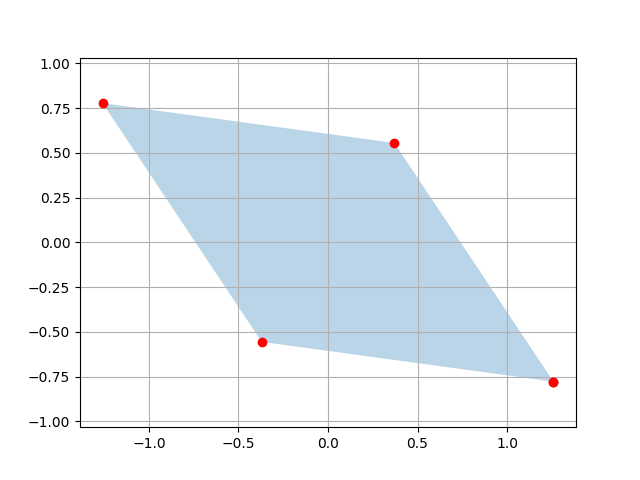

In [22]:
def plot_polygon(A, b):
    '''
    Visualize the polytope defined by A x <= b.
    '''
    halfspaces = np.hstack((A, -b[:, np.newaxis]))
    feasible_point = np.zeros(A.shape[1])
    hs = HalfspaceIntersection(halfspaces, feasible_point)
    polygon = Polygon(hs.intersections).convex_hull
    polygon_gpd = gpd.GeoSeries(polygon)
    polygon_gpd.plot(alpha=0.3)
    plt.plot(*polygon.exterior.xy, 'ro')
    plt.axis('equal')
    plt.grid()

for A_inf, b_inf in zip(A_inf_hist, b_inf_hist):
    plot_polygon(A_inf, b_inf)

## Compute $\mathcal{X}_N$

We first compute the feasible set $\mathcal{X}_1$ for the system $x^+ = Ax + Bu$ subject to constraints $Gx + Hu + \psi <= 0$ and $x^+ \in \mathcal{X}_f$. The feasible set $\mathcal{X}_2$ is then caculated based on $\mathcal{X}_1$. This process is repeated iteratively until we obtain $\mathcal{X}_N$.

In [23]:
from utils import proj_input

def computeX1(G, H, psi, Ad, Bd, P, gamma): # TODO: Add support for the point constraint 
    '''
    Computes the feasible set X_1 for the system x^+ = Ax + Bu subject to constraints Gx + Hu <= psi and x^+ \in Xf.
    '''
    dim_u = Bd.shape[1]
    G_ = np.vstack((G, P @ Ad))
    H_ = np.vstack((H, P @ Bd))
    psi_ = np.hstack((psi, -gamma))
    
    psi_ = np.expand_dims(psi_, axis=1)
    
    A, b = proj_input(G_, H_, psi_, 1, dim_u)
    b = -b.squeeze()
    
    return A, b

def computeXn(A, B, K, N, lb_x, ub_x, lb_u, ub_u):
    '''
    
    '''
    A_x, b_x = box_constraints(lb_x, ub_x)
    A_u, b_u = box_constraints(lb_u, ub_u)

    A_lqr = A_u @ K
    b_lqr = b_u

    A_con = np.vstack((A_lqr, A_x))
    b_con = np.hstack((b_lqr, b_x))

    F = A + B @ K
    
    A_inf_hist, b_inf_hist = compute_maximal_admissible_set(F, A_con, b_con)
    _, A_inf, b_inf, _, _ = remove_redundant_constraints(A_inf_hist[-1], b_inf_hist[-1])
   
    GH = sp.linalg.block_diag(A_x, A_u)
    G = GH[:, :dim_x]
    H = GH[:, dim_x:]
    psi = -np.hstack((b_x, b_u))
   
    # Xns = [(A_inf_hist[-1], b_inf_hist[-1])]   
    Xns = [(A_inf, b_inf)] 
    
    for _ in range(N):
        P, gamma = Xns[-1]
        P, gamma = computeX1(G, H, psi, A, B, P, gamma)        
        _, P, gamma, _, _ = remove_redundant_constraints(P, gamma)
        Xns.append((P, gamma))

    return Xns

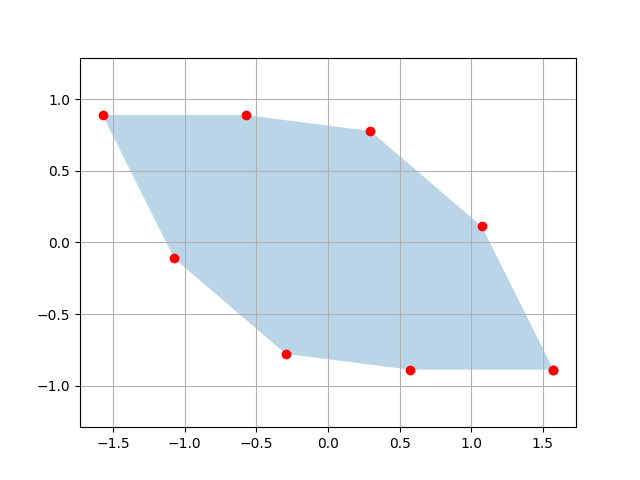

In [24]:
import scipy as sp

A_x, b_x = box_constraints(lb_x, ub_x)
A_u, b_u = box_constraints(lb_u, ub_u)

A_lqr = A_u @ K
b_lqr = b_u

A_con = np.vstack((A_lqr, A_x))
b_con = np.hstack((b_lqr, b_x))

A_inf_hist, b_inf_hist = find_lqr_invariant_set(A, B, K, lb_x, ub_x, lb_u, ub_u)

P = A_inf_hist[-1]
gamma = b_inf_hist[-1]
GH = sp.linalg.block_diag(A_x, A_u)
G = GH[:, :dim_x]
H = GH[:, dim_x:]
psi = -np.hstack((b_x, b_u))

# gamma = np.expand_dims(gamma, axis=1)
# psi = np.expand_dims(psi, axis=1)

A_X1, b_X1 = computeX1(G, H, psi, A, B, P, gamma)
plot_polygon(A_X1, b_X1.squeeze())

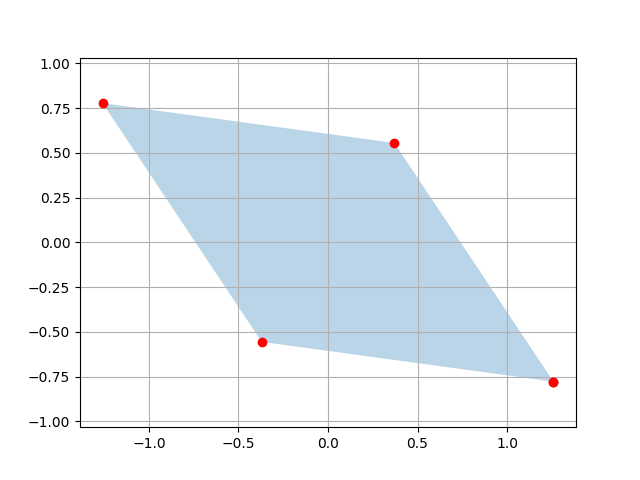

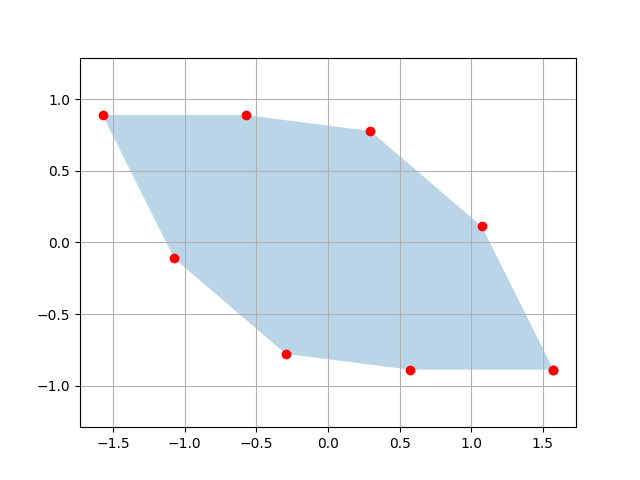

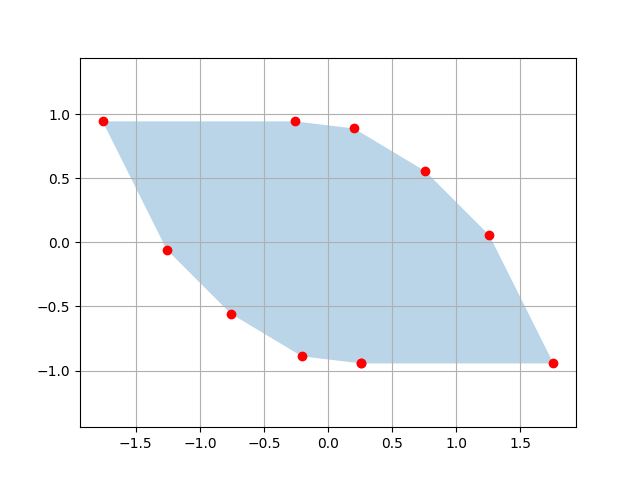

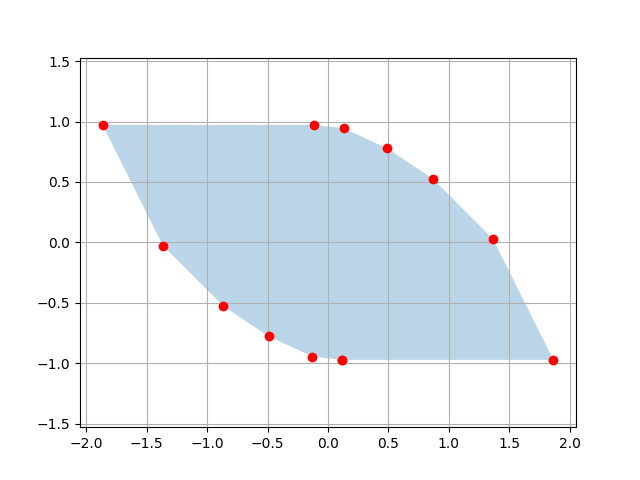

In [25]:
N = 3
Xns = computeXn(A, B, K, N, lb_x, ub_x, lb_u, ub_u)
for Xn in Xns:
    plot_polygon(Xn[0], Xn[1].squeeze())